In [593]:
import psycopg2
import pandas as pd
import re
from multiprocessing import Pool
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

In [3]:
connection = psycopg2.connect(user="postgres", password="postgres", host="127.0.0.1", port="54320", database="stack_overflow")

In [565]:
with connection.cursor() as cursor:
    cursor.execute("select location from users where location is not null;")
    locations = cursor.fetchall()
    locations = [l[0] for l in locations]

In [566]:
len(locations), locations[:2]

(4096670, ['London, United Kingdom', 'Jerusalem, Israel'])

The following dataframes are created with the cities5000.txt and countryInfo.txt files from https://download.geonames.org/export/dump/

In [567]:
cities_df = pd.read_csv("cities5000.txt", delimiter="\t", header=None, usecols=[1,2,3,8])
cities_df.head(2)

,1,2,3,8
0,Sant Julià de Lòria,Sant Julia de Loria,"San Julia,San Julià,Sant Julia de Loria,Sant J...",AD
1,Ordino,Ordino,"Ordino,ao er di nuo,orudino jiao qu,Ордино,オルデ...",AD


In [568]:
countries_df = pd.read_csv("countryInfo.txt", delimiter="\t", usecols=["ISO", "Country"])
countries_df.head(2)

,ISO,Country
0,AD,Andorra
1,AE,United Arab Emirates


In [569]:
cities_df = cities_df.join(countries_df.set_index('ISO'), on=8)

In [570]:
cc_delim_begin = r"\b(" 
cc_delim_end = r")\b"

cities_df[1]=cities_df[1].str.lower()
cities_df[2]=cities_df[2].str.lower()

countries_names = re.compile(cc_delim_begin+ "|".join(cities_df["Country"].unique()) + cc_delim_end, re.IGNORECASE)
cities_names_1 = re.compile(cc_delim_begin+ "|".join(cities_df[1].apply(lambda x: re.escape(x))) + cc_delim_end, re.IGNORECASE)
cities_names_2 = re.compile(cc_delim_begin+"|".join(cities_df[~cities_df[2].isna()][2].apply(lambda x: re.escape(x))) + cc_delim_end, re.IGNORECASE)

In [571]:
country_regex = cities_df[["Country", 3]].dropna()
country_regex[3] = country_regex[3].apply(lambda x: re.escape(x))
country_regex[3] = cc_delim_begin+ country_regex[3].str.replace(",", "|") +cc_delim_end
country_regex = country_regex.values

In [572]:
country_regex = [(c, re.compile(r, re.IGNORECASE)) for c, r in country_regex]

In [575]:
def search_country(loc_text):
    try:
        country_match = countries_names.search(loc_text)
        if country_match is not None:
            return (loc_text, country_match.group(0))
            
        city_match = cities_names_1.search(loc_text)
        if city_match is not None:
            return (loc_text, cities_df[cities_df[1] == city_match.group(1).lower()]["Country"].iloc[0])

        city_match = cities_names_2.search(loc_text)
        if city_match is not None:
            return (loc_text, cities_df[cities_df[2] == city_match.group(1).lower()]["Country"].iloc[0])
            
        for country, c_regex in country_regex:
            if c_regex.search(loc_text) is not None:
                return (loc_text, country)
        return (loc_text, None)
    except:
        return (loc_text, "Error")

In [576]:
with Pool(8) as p:
    maped_countries = p.map(search_country, locations)

In [578]:
maped_countries = pd.DataFrame(maped_countries, columns =['location', 'country'])

In [583]:
print("Total locations:", len(maped_countries))
print("Locations without match:", maped_countries["country"].isna().sum())
print("Errors during matching:", (maped_countries["country"]=="Error").sum())

Total locations: 4096670
Locations without match: 208567
Errors during matching: 12566


In [581]:
maped_countries["country"].value_counts()[:10]

India             710832
United States     506019
United Kingdom    164877
Canada            149501
Germany           131894
Australia         113345
Brazil            107610
China             106541
France             84867
Pakistan           80377
Name: country, dtype: int64

<AxesSubplot:>

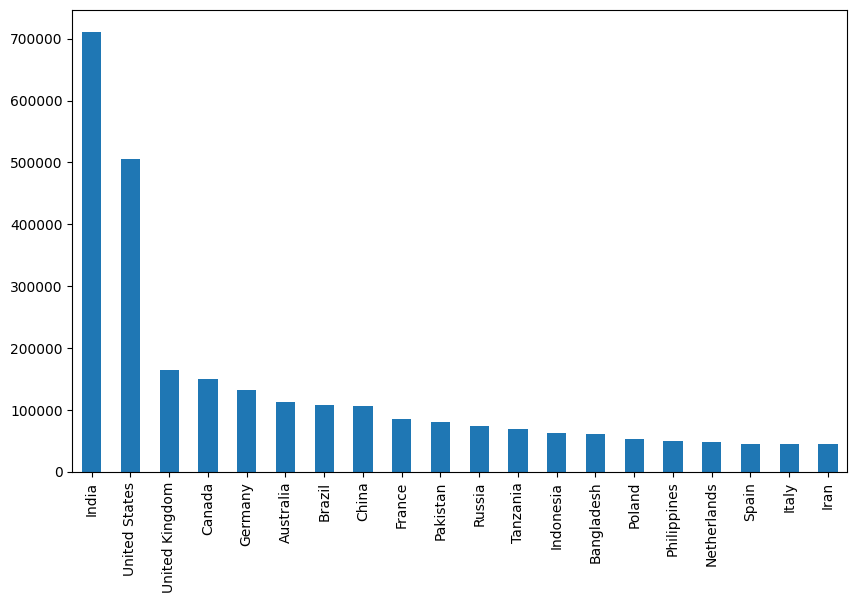

In [594]:
maped_countries["country"].value_counts()[:20].plot(kind="bar")

In [595]:
maped_countries["country"].value_counts(normalize=True)[:10]

India             0.182822
United States     0.130145
United Kingdom    0.042406
Canada            0.038451
Germany           0.033922
Australia         0.029152
Brazil            0.027677
China             0.027402
France            0.021827
Pakistan          0.020673
Name: country, dtype: float64